In [43]:
import pandas as pd
import datetime
import pandas_datareader.data as web
from pandas import Series, DataFrame
import math
import numpy as np
import sklearn.preprocessing as preprocessing

In [5]:
start = datetime.datetime(2010,1,1)
end = datetime.datetime(2017,1,11)

df = web.DataReader("AAPL", 'yahoo', start, end)
df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2017-01-05,29.215000,28.952499,28.980000,29.152500,88774400.0,27.657520
2017-01-06,29.540001,29.117500,29.195000,29.477501,127007600.0,27.965857
2017-01-09,29.857500,29.485001,29.487499,29.747499,134247600.0,28.222006
2017-01-10,29.844999,29.575001,29.692499,29.777500,97848400.0,28.250471
2017-01-11,29.982500,29.650000,29.684999,29.937500,110354400.0,28.402262


In [16]:
#Rolling mean
close_px = df['Adj Close']
mavg = close_px.rolling(window = 100).mean()

Date
2017-01-05    26.549033
2017-01-06    26.570354
2017-01-09    26.594472
2017-01-10    26.619252
2017-01-11    26.645881
Name: Adj Close, dtype: float64

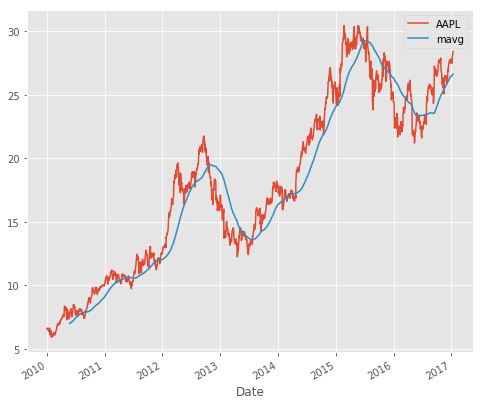

In [11]:
#Plotting
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style

#Adjusting the size of matplotlib
import matplotlib as mpl
mpl.rc('figure', figsize = (8,7))
mpl.__version__

#Adjusting the style of matplotlib
style.use('ggplot')

close_px.plot(label = 'AAPL')
mavg.plot(label = 'mavg')
plt.legend()

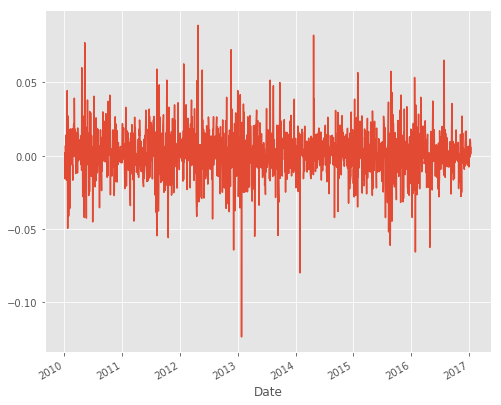

In [12]:
#Expected Return - to determine risk and return
rets = close_px / close_px.shift(1) - 1

rets.plot(label = 'return')

In [15]:
#Analysing competitors stock
dfcomp = web.DataReader(['AAPL', 'GE', 'GOOG', 'IBM', 'MSFT']
                       , 'yahoo', start = start, end = end)['Adj Close']
dfcomp.tail()

Symbols,AAPL,GE,GOOG,IBM,MSFT
Date,,,,,
2017-01-05,27.657520,27.838821,794.020020,142.916901,58.563644
2017-01-06,27.965857,27.918308,806.150024,143.620056,59.071262
2017-01-09,28.222006,27.785828,806.650024,142.027374,58.883255
2017-01-10,28.250471,27.706337,804.789978,140.222916,58.864449
2017-01-11,28.402262,27.794657,807.909973,142.112076,59.400265


In [18]:
#Correlation Analysis
retscomp = dfcomp.pct_change()
corr = retscomp.corr()

corr.tail()

Symbols,AAPL,GE,GOOG,IBM,MSFT
Symbols,,,,,
AAPL,1.000000,0.381502,0.411692,0.383839,0.393467
GE,0.381502,1.000000,0.422301,0.535173,0.474069
GOOG,0.411692,0.422301,1.000000,0.403014,0.472083
IBM,0.383839,0.535173,0.403014,1.000000,0.496674
MSFT,0.393467,0.474069,0.472083,0.496674,1.000000


Text(0, 0.5, 'Returns GE')

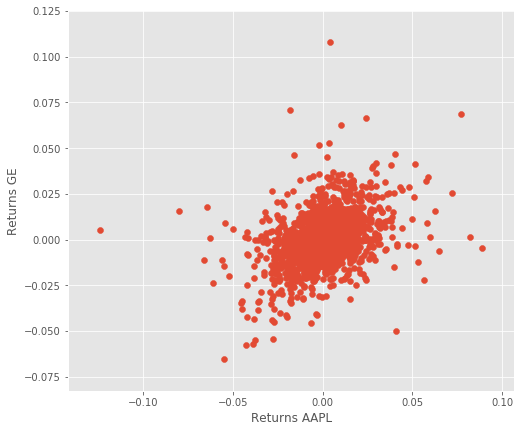

In [21]:
#Plotting Apple and GE with scatterplot
plt.scatter(retscomp.AAPL, retscomp.GE)
plt.xlabel('Returns AAPL')
plt.ylabel('Returns GE')

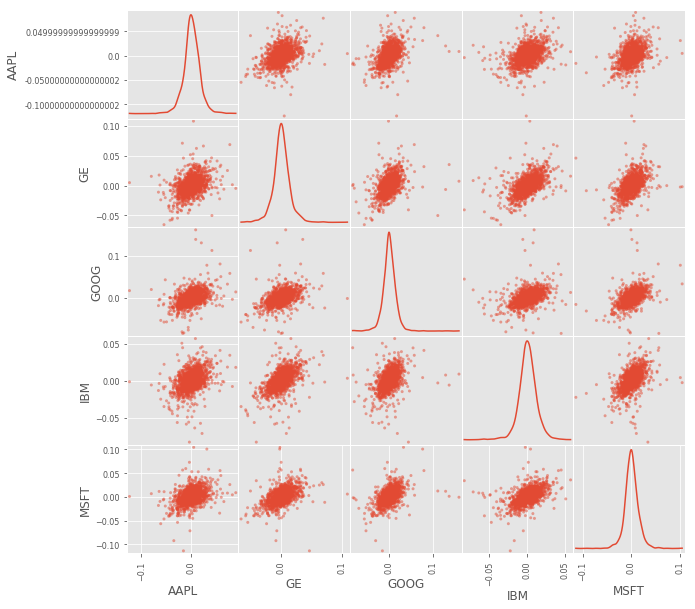

In [26]:
pd.plotting.scatter_matrix(retscomp, diagonal = 'kde', figsize = (10,10));

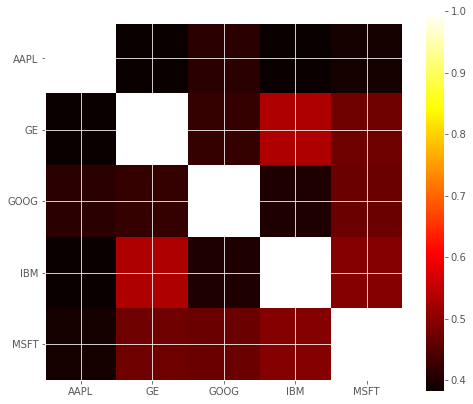

In [29]:
#Heat maps to visualize the correlation
plt.imshow(corr, cmap = 'hot', interpolation = 'none')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns)
plt.yticks(range(len(corr)), corr.columns);

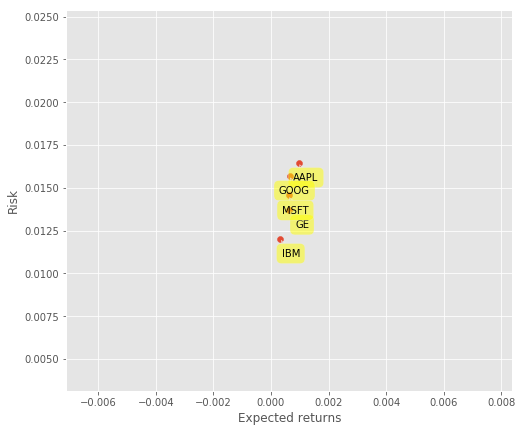

In [32]:
#Stocks Returns Rate and Risk
#Apart from correlation, we also analyse each stock’s risks and returns. In this case we are extracting the average of returns (Return Rate) and the standard deviation of returns (Risk).

plt.scatter(retscomp.mean(), retscomp.std())
plt.xlabel('Expected returns')
plt.ylabel('Risk')
for label, x, y in zip(retscomp.columns, retscomp.mean(), retscomp.std()):
    plt.annotate(
        label, 
        xy = (x, y), xytext = (20, -20), 
        textcoords = 'offset points', ha = 'right', va = 'bottom', 
        bbox = dict(boxstyle = 'round, pad = 0.5', fc = 'yellow', 
        alpha = 0.5), 
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3, rad = 0'))

In [33]:
#Predicting Stocks Price
#Feature Engineering

dfreg = df.loc[:, ['Adj Close', 'Volume']]
dfreg['HL_PCT'] = (df['High'] - df['Low']) / df['Close'] * 100.0
dfreg['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0

In [34]:
dfreg.tail()

,Adj Close,Volume,HL_PCT,PCT_change
Date,,,,
2017-01-05,27.657520,88774400.0,0.900440,0.595240
2017-01-06,27.965857,127007600.0,1.433299,0.967636
2017-01-09,28.222006,134247600.0,1.252204,0.881730
2017-01-10,28.250471,97848400.0,0.906720,0.286271
2017-01-11,28.402262,110354400.0,1.110649,0.850600


In [51]:
#Pre-processing

# Drop missing value
dfreg.fillna(value=-99999, inplace=True)

# We want to separate 1 percent of the data to forecast
forecast_out = int(math.ceil(0.01 * len(dfreg)))

# Separating the label here, we want to predict the AdjClose
forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)
X = np.array(dfreg.drop(['label'], 1))

# Scale the X so that everyone can have the same distribution for linear regression
X = preprocessing.scale(X)

# Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
X_lately = X[-forecast_out:]
X_train = X[:-forecast_out]

# Separate label and identify it as y
y = np.array(dfreg['label'])
y_train = y[:-forecast_out]

E:\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:176: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


In [52]:
#sklearn imports
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [53]:
#Training models

# Linear regression
clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(X_train, y_train)
# Quadratic Regression 2
clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
clfpoly2.fit(X_train, y_train)

# Quadratic Regression 3
clfpoly3 = make_pipeline(PolynomialFeatures(3), Ridge())
clfpoly3.fit(X_train, y_train)

# KNN Regression
clfknn = KNeighborsRegressor(n_neighbors=2)
clfknn.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=2, p=2,
          weights='uniform')

In [60]:
#Evaluation
confidencereg = clfreg.score(X_test, y_test)
confidencepoly2 = clfpoly2.score(X_test,y_test)
confidencepoly3 = clfpoly3.score(X_test,y_test)
confidenceknn = clfknn.score(X_test, y_test)


NameError: name 'X_test' is not defined

In [58]:
#Sanity checks
forecast_set = clf.predict(X_lately)
dfreg['Forecast'] = np.nan

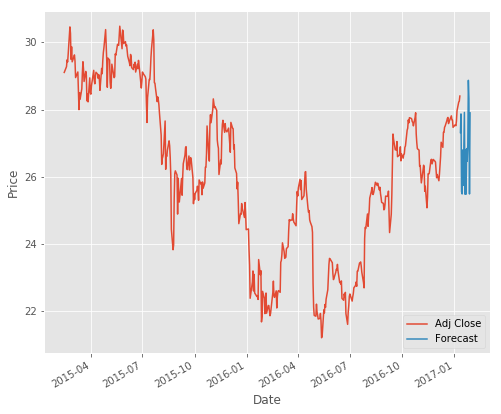

In [59]:
#Plotting the Prediction
last_date = dfreg.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]
dfreg['Adj Close'].tail(500).plot()
dfreg['Forecast'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()